## Library

In [ ]:
pip install pyvi

In [ ]:
# pip install tensorflow-gpu==2.1

In [ ]:
# pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import re
import pickle

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing import text, sequence

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from pyvi.ViTokenizer import ViTokenizer

## Data loader

In [ ]:
DATA = '/content/drive/MyDrive/NLP/vihsd/train.csv'
DEV_DATA = '/content/drive/MyDrive/NLP/vihsd/dev.csv'
TEST_DATA = '/content/drive/MyDrive/NLP/vihsd/test.csv'

# read data
train_data = pd.read_csv(DATA)
dev_data = pd.read_csv(DEV_DATA)
test_data = pd.read_csv(TEST_DATA)

print(len(train_data))
print(len(dev_data))
print(len(test_data))

X_train = train_data['free_text']
y_train = train_data['label_id'].values

X_dev = dev_data['free_text']
y_dev = dev_data['label_id'].values

X_test = test_data['free_text']
y_test = test_data['label_id'].values

24048
2672
6680


## Data pre-proccessing

In [ ]:
STOPWORDS = '/content/drive/MyDrive/NLP/vietnamese-stopwords-dash.txt'
with open(STOPWORDS, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

# --------------TRICH XUAT DAC TRUNG -------------------------
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

train_X, train_y = pre_process_features(X_train, y_train, tokenized=True, lowercased = True)
dev_X, dev_y = pre_process_features(X_dev, y_dev, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [ ]:
len(test_X)

6680

## Feature Extraction

In [ ]:
EMBEDDING_FILE = '/content/drive/MyDrive/NLP/cc.vi.300.vec'
embedding_dim = 300
vocabulary_size = 10000

# --------------LOAD WORD EMBEDDING -------------------------
embeddings_index = {}
with open(EMBEDDING_FILE, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open('/content/drive/MyDrive/NLP/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

word_index = tokenizer.word_index
# num_words = min(vocabulary_size, len(word_index) + 1)
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
len(word_index)

19656

In [ ]:
for word, i in word_index.items():
  if word=='Cuong_ly':
    print(word,i)
    break

In [ ]:
for word, i in word_index.items():
  if i>=19000:
    print(word, i)

ic 19000
thì_chớ 19001
mớm 19002
châu_hạ_nghi 19003
nhâyy 19004
hoàng_vân 19005
giấy_🤒 19006
tiền_tuyến 19007
nhàng 19008
noooo 19009
david504 19010
cộng_thành 19011
tạo_hoá 19012
nghệ_thuật_hóa 19013
timm 19014
meow 19015
ương 19016
đạm_bạc 19017
trống_rỗng 19018
yasuo 19019
tt6 19020
tt5 19021
việt_nam_r 19022
nguyễn_phan_gia_phát 19023
nông_tuấn 19024
điệu_này 19025
nha_thánh 19026
giục 19027
công_xưởng 19028
vàng_khè 19029
ganh_tị 19030
minh_hoạ 19031
bớt_tỏa 19032
giàu_thế 19033
phan_eric 19034
zẩy 19035
nhà_bà 19036
quang_ly 19037
phạm_trân 19038
nobi 19039
nguoi_ta 19040
quẽ 19041
phạmlừa 19042
hnh 19043
ngọc_tính 19044
lần_lượt 19045
bình_thản 19046
xúc_cảm 19047
toan_tính 19048
thị_phi 19049
châu_hạ_nghi_duma 19050
chếttt 19051
măm 19052
dúng 19053
thân_nhiệt 19054
kieu_minh 19055
lê_thanh_thảo 19056
lân_lặp 19057
chập_chững 19058
bán_đảo 19059
trần_mai_phương_âm_tính 19060
chi3 19061
oxin 19062
liveshow 19063
phạm_trà_my 19064
áy 19065
ác_nghiệp 19066
hữu_an 19067
bích_loan 1

In [ ]:
embeddings_index.get('oai')

array([ 0.0765, -0.0723,  0.2444,  0.0622,  0.0206,  0.0634, -0.0446,
        0.2336, -0.104 ,  0.0822, -0.0803,  0.0929,  0.0189,  0.0742,
        0.1802, -0.1056,  0.0012,  0.0876,  0.0312, -0.0268,  0.1847,
       -0.0544,  0.1107,  0.0988,  0.0417, -0.1563, -0.0726,  0.0467,
       -0.2554,  0.1037,  0.0399,  0.0076, -0.0187, -0.156 , -0.0588,
       -0.0643, -0.1709,  0.0139, -0.0493, -0.2263,  0.0058, -0.028 ,
       -0.009 ,  0.0412,  0.0287,  0.2933,  0.0144, -0.1396, -0.0394,
        0.0943, -0.0675, -0.1162, -0.1355,  0.1816,  0.1142, -0.2455,
       -0.0031,  0.0241, -0.1327, -0.0023,  0.1443, -0.1112, -0.0751,
        0.0112, -0.2212, -0.0683,  0.0652,  0.0057,  0.1778, -0.0828,
        0.0117, -0.0577,  0.2298,  0.0404, -0.1595,  0.1196,  0.0491,
        0.1755, -0.0657, -0.0318,  0.0212,  0.0202, -0.1909,  0.1173,
        0.0015,  0.0054, -0.0708,  0.1256, -0.1478, -0.1313,  0.1885,
        0.0555,  0.1538,  0.0131,  0.0717,  0.0605,  0.2142,  0.0867,
       -0.0863, -0.0

In [ ]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
sequence_length = 100

def make_featues(X, y, tokenizer, is_one_hot_label=True):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label:
        y = to_categorical(y, num_classes=3)

    return X, y

# Make features
train_X, train_y = make_featues(train_X, train_y, tokenizer)
dev_X, dev_y = make_featues(dev_X, dev_y, tokenizer)
test_X, test_y = make_featues(test_X, test_y, tokenizer, is_one_hot_label=False)


In [ ]:
train_X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  222,   46,
        265, 6131, 9102, 3613,   76,   30,  198,   47,   46,   30,  157,
        181], dtype=int32)

## Text CNN (Convolutional neural network for text classification)

In [ ]:
MODEL_FILE = '/content/drive/MyDrive/NLP/Text_CNN_model.h5'
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=3, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 300)             5897100   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 100, 300, 1)          0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 99, 1, 32)            19232     ['reshape[0][0]']             
                                                                                              

In [ ]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_X, train_y, batch_size=batch_size, epochs=epochs, verbose=1,
          validation_data=(dev_X, dev_y))
model.save(MODEL_FILE)

Epoch 1/40
94/94 [==============================] - 31s 212ms/step - loss: 0.8511 - accuracy: 0.7365 - val_loss: 0.6874 - val_accuracy: 0.8196
Epoch 2/40
94/94 [==============================] - 9s 98ms/step - loss: 0.6267 - accuracy: 0.8268 - val_loss: 0.5882 - val_accuracy: 0.8196
Epoch 3/40
94/94 [==============================] - 7s 70ms/step - loss: 0.5396 - accuracy: 0.8292 - val_loss: 0.5290 - val_accuracy: 0.8215
Epoch 4/40
94/94 [==============================] - 4s 43ms/step - loss: 0.4894 - accuracy: 0.8373 - val_loss: 0.4954 - val_accuracy: 0.8267
Epoch 5/40
94/94 [==============================] - 6s 67ms/step - loss: 0.4549 - accuracy: 0.8441 - val_loss: 0.4703 - val_accuracy: 0.8342
Epoch 6/40
94/94 [==============================] - 6s 59ms/step - loss: 0.4280 - accuracy: 0.8510 - val_loss: 0.4516 - val_accuracy: 0.8391
Epoch 7/40
94/94 [==============================] - 4s 40ms/step - loss: 0.3993 - accuracy: 0.8603 - val_loss: 0.4367 - val_accuracy: 0.8417
Epoch 8/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
prediction = model.predict(test_X, batch_size=batch_size, verbose=0)
y_pred = prediction.argmax(axis=-1)

[[5323   66  159]
 [ 235  125   84]
 [ 306   44  338]]
F1 - micro: 0.8661676646706586
F1 - macro: 0.6112563669417851
Accuracy: 0.8661676646706586


<Axes: >

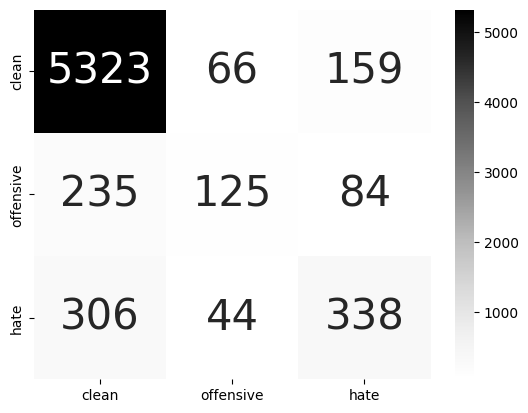

In [ ]:
cf1 = confusion_matrix(test_y, y_pred)
print(cf1)

evaluation = f1_score(test_y, y_pred, average='micro')

print("F1 - micro: " + str(evaluation))

evaluation = f1_score(test_y, y_pred, average='macro')
print("F1 - macro: " + str(evaluation))

evaluation = accuracy_score(test_y, y_pred)
print("Accuracy: " + str(evaluation))

df_cm1 = pd.DataFrame(cf1, index = ["clean","offensive","hate"],
                  columns = ["clean","offensive","hate"])
plt.clf()
sn.heatmap(df_cm1, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})

In [ ]:
incorrect_predictions = []
comment_test = test_data['free_text']

for i in range(len(test_y)):
    if y_pred[i] != test_y[i]:
        incorrect_predictions.append({
            'index': i,
            'predicted_label': y_pred[i],
            'true_label': test_y[i],
            'comment_text': comment_test[i]
        })

df_incorrect_predictions = pd.DataFrame(incorrect_predictions)

# In ra các mẫu sai có nhãn 0
df_label_0 = df_incorrect_predictions[df_incorrect_predictions['true_label'] == 0]
df_label_0


,index,predicted_label,true_label,comment_text
0,0,2,0,Đừng cố biện minh =)))) choi lon
2,3,2,0,Mua cho em hộp bcs mĩ sài cho oai :))
8,43,2,0,Phét
12,77,2,0,Công an mà muốn xử lý thì 2 ông luật sư này sẽ...
14,129,2,0,Vay về cho cán bộ xây biệt thự con em đi du học
...,...,...,...,...
876,6488,2,0,Thôi chờ Mỹ giải phóng xong ta ra xin lại vậy....
882,6534,1,0,May quá đéo có tiền mua xe
883,6576,2,0,Ch xem đã biết top1:))
888,6636,2,0,Đưa từ vụ bán độ lịch sử 4 cái tàu choán nước ...


In [ ]:
# In ra các mẫu sai có nhãn 1
df_label_1 = df_incorrect_predictions[df_incorrect_predictions['true_label'] == 1]
df_label_1

,index,predicted_label,true_label,comment_text
1,1,0,1,Haizz. Nthe này thì dân khổ quá
3,4,0,1,coin card :3
6,32,0,1,Trần Linh dell hiểu kiểu gì :))
7,34,0,1,"K nói thì tự kiêu,nói thì lại tự ái chứ í thức..."
9,60,0,1,Một phút bóc đồng bằng cả đời bóc cức 😂
...,...,...,...,...
884,6598,2,1,giong ca lozz trong lang fo
885,6601,0,1,Hội chứng tự hào bở ảo tưởng
887,6634,2,1,Khi bạn muốn bợ đít ai đó nhưng bạn không có n...
889,6637,0,1,Tranh cho va bong sa ban gai cung kg gai trai ...


In [ ]:
# In ra các mẫu sai có nhãn 2
df_label_2 = df_incorrect_predictions[df_incorrect_predictions['true_label'] == 2]
df_label_2

,index,predicted_label,true_label,comment_text
4,22,0,2,(Y) page này ad nó kiến thức uyên sâu lắm từ x...
5,23,0,2,"Đề nghị 17, 22,23,32 đến phà vài hơi vào mẹt t..."
11,76,0,2,Theo trung cộng đi rồi đến lúc ko còn lợi dụng...
13,113,0,2,Đem ra bắn ngay cái thể loại ấy
15,131,0,2,Hải Yến bố cái con thái lọ
...,...,...,...,...
879,6509,0,2,Phạm Văn Lộc vãi lol lộc
881,6531,0,2,Cô ba sạo lồn quá
886,6611,0,2,giống lão gà mên teong là xì trum vl
890,6659,0,2,Cám ơn đảng. Cám ơn nhà nc 😏


In [ ]:
from tensorflow.keras.models import load_model
MODEL_FILE = '/content/drive/MyDrive/NLP/Text_CNN_model.h5'
# Load the model
model = load_model(MODEL_FILE)

def TextPredict(txt):
    # Load the tokenizer from the saved file
    with open('/content/drive/MyDrive/NLP/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # Preprocess the input sentence
    input_sentence = preprocess(txt, tokenized=True, lowercased=True)
    print(input_sentence)
    
    # Tokenize and pad the input sentence
    input_sequence = tokenizer.texts_to_sequences([input_sentence])
    print(input_sequence)
    input_sequence = sequence.pad_sequences(input_sequence, maxlen=sequence_length)
    print(input_sequence)
    # Make the prediction
    predictions = model.predict(input_sequence)
    
    # The predictions array contains the probabilities for each class
    # You can print the predicted class or the entire array as needed
    predicted_class = np.argmax(predictions)
    print(f"Predicted Class: {predicted_class}")
    print("Predictions Probabilities:")
    print(predictions)

TextPredict("cc")

cc
[[185]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 185]]
1/1 [==============================] - 1s 741ms/step
Predicted Class: 1
Predictions Probabilities:
[[0.0219388  0.8547076  0.12335368]]
